# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline



### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Quick look for Udacity_AZDIAS_Subset.csv, Demographic Data
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Quick look for AZDIAS_Feature_Summary.csv, Feature summary of Demographic Data
print(feat_info.shape)
feat_info.head(5)


(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
print(f"Natural missing: {azdias.isna().sum().sum()}")

Natural missing: 4896838


In [11]:
def get_data_type(col_name):
    
    a = [int, float, str]
    b = None
    data_type = azdias[col_name].dtype

    if (data_type == 'int'):
        b = a[0]
    elif (data_type == 'float'):
        b = a[1]
    else:
        b = a[2]
    
    return b

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_filled_na = azdias.copy()

for i, col_name in enumerate(list(azdias_filled_na.columns)):
    missing_or_unknown_values = feat_info['missing_or_unknown'][i]
    missing_or_unknown_values_list = missing_or_unknown_values[1:-1].split(',')
        
    if(missing_or_unknown_values != '[]'):
        data_type = get_data_type(col_name)
        missing_or_unknown_values_list = list(map(data_type, missing_or_unknown_values_list))
        azdias_filled_na[col_name].replace(missing_or_unknown_values_list, np.nan, inplace=True)                                     
    
azdias_filled_na.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
print(f"After fill na missing: {azdias_filled_na.isna().sum().sum()}")

After fill na missing: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# list contain the percentage of missing values in each column of azdias_filled_na
mis_percentages_col = []
n_rows = azdias_filled_na.shape[0]

mis_percentages_col = azdias_filled_na.isna().sum(axis=0) / n_rows
mis_percentages_col[:5]

AGER_TYP                0.769554
ALTERSKATEGORIE_GROB    0.003233
ANREDE_KZ               0.000000
CJT_GESAMTTYP           0.005446
FINANZ_MINIMALIST       0.000000
dtype: float64

(array([ 32.,   7.,  37.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.04987882,  0.09975764,  0.14963645,  0.19951527,
         0.24939409,  0.29927291,  0.34915173,  0.39903054,  0.44890936,
         0.49878818,  0.548667  ,  0.59854582,  0.64842463,  0.69830345,
         0.74818227,  0.79806109,  0.8479399 ,  0.89781872,  0.94769754,
         0.99757636]),
 <a list of 20 Patch objects>)

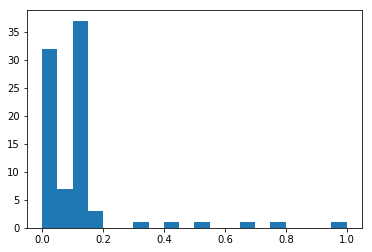

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist([mis_percentages_col], bins=20)

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Splitting mis_percentages to two columns by threshold 0.2

threshold = 0.2

not_outlier_column_names = mis_percentages_col[mis_percentages_col <= threshold].index
outlier_column_names = mis_percentages_col[mis_percentages_col > threshold].index
        
azdias_col_outlier_filtered = azdias_filled_na[not_outlier_column_names].copy()
azdias_col_outlier_filtered.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
outlier_column_names

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Missing pattern: 0% - 5%, 10% - 15%


Decided to remove columns: have missing percentage > 20%


Removed columns: ['AGER_TYP',
 'GEBURTSJAHR',
 'GREEN_AVANTGARDE',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'ALTER_HH',
 'ANZ_TITEL',
 'KK_KUNDENTYP',
 'ANZ_HH_TITEL',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?

# list contain the percentage of missing values in each rows of azdias_col_outlier_filtered
mis_percentages_row = []

mis_percentages_row = azdias_col_outlier_filtered.isna().sum(axis=1)
mis_percentages_row[:5]

0    43
1     0
2     0
3     7
4     0
dtype: int64

(array([  6.38947000e+05,   2.79260000e+04,   1.76290000e+04,
          1.26070000e+04,   3.62860000e+04,   1.37140000e+04,
          2.45920000e+04,   3.04200000e+03,   6.53700000e+03,
          7.66000000e+02,   3.25500000e+03,   2.24300000e+03,
          4.74300000e+03,   3.18200000e+03,   4.28000000e+02,
          1.18000000e+03,   3.49000000e+02,   2.79000000e+02,
          1.32000000e+02,   6.90000000e+01,   5.50000000e+01,
          5.90000000e+01,   2.90000000e+01,   1.20000000e+01,
          6.00000000e+00,   3.00000000e+00,   3.19100000e+03,
          1.08160000e+04,   3.91100000e+03,   8.40000000e+01,
          5.38000000e+02,   4.98000000e+02,   1.37000000e+02,
          3.56000000e+02,   2.10000000e+01,   2.75240000e+04,
          4.94000000e+02,   0.00000000e+00,   4.55780000e+04,
          3.00000000e+00]),
 array([  0.   ,   1.225,   2.45 ,   3.675,   4.9  ,   6.125,   7.35 ,
          8.575,   9.8  ,  11.025,  12.25 ,  13.475,  14.7  ,  15.925,
         17.15 ,  18.375

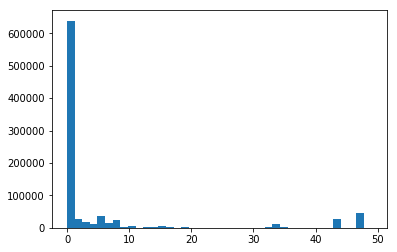

In [19]:
plt.hist(mis_percentages_row, bins=40)

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# threshold: number of missing values allowed in each row

threshold = 3

rows_below_threshold_id = mis_percentages_row[mis_percentages_row <= threshold].index
rows_above_threshold_id = mis_percentages_row[mis_percentages_row > threshold].index

azdias_outlier_filtered = azdias_col_outlier_filtered.iloc[rows_below_threshold_id, :]
azdias_outlier_rows = azdias_col_outlier_filtered.iloc[rows_above_threshold_id, :]

In [21]:
# In azdias_outlier_filtered, choose 5 columns which has the lowest mis_percentages_col

threshold = 0.2
not_outlier_column = mis_percentages_col[mis_percentages_col <= threshold]

# Top 5 columns are not missing data (or are missing very little data)
top = 5
highest_not_mis_col_names = list(not_outlier_column.sort_values(ascending=True).index[:top])
highest_not_mis_col_names

['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST']

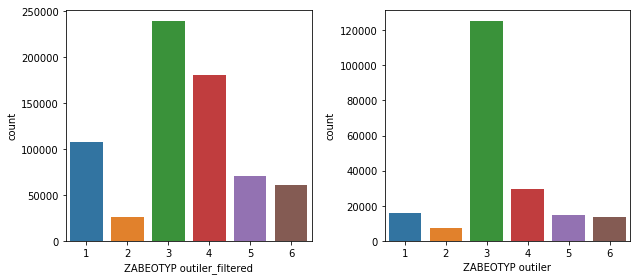

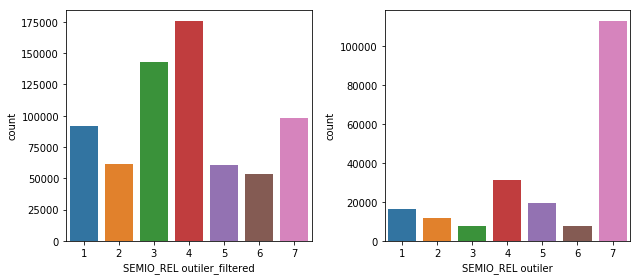

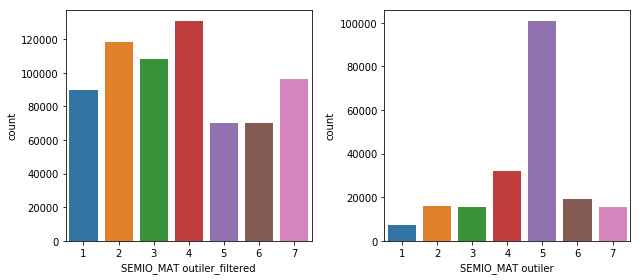

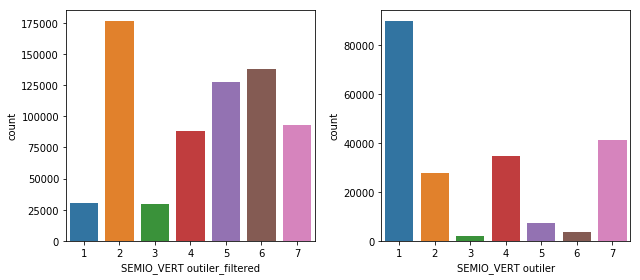

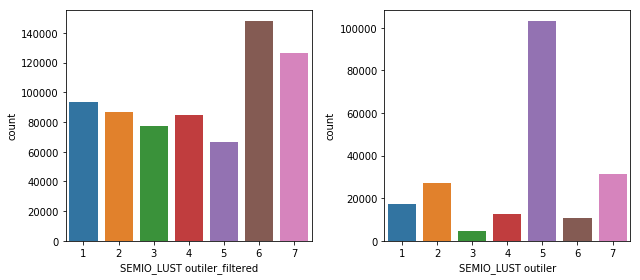

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution(col_name):
    
    f = plt.figure(figsize=(9,4))

    ax1 = f.add_subplot(1, 2, 1)
    ax1 = sns.countplot(x=col_name, data = azdias_outlier_filtered)
    ax1.set_xlabel(col_name + ' outiler_filtered')

    ax2 = f.add_subplot(1, 2, 2)
    ax2 = sns.countplot(x=col_name, data = azdias_outlier_rows)
    ax2.set_xlabel(col_name + ' outiler')
    

    plt.tight_layout()

for col_name in highest_not_mis_col_names:
    compare_distribution(col_name)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Most of rows has number of missing data: <10 

**Conclusion:**
The data with lots of missing values are qualitatively different from data with few or no missing values


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Get feature info of only filltered columns 
feat_info_filtered_columns = feat_info[feat_info['attribute'].isin(list(azdias_outlier_filtered.columns))].copy()
feat_info_filtered_columns.shape

(79, 4)

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get names of catgorical columns
cate_col_names = feat_info_filtered_columns[feat_info['type'] == 'categorical']['attribute']

# Multilevel columns needed encode
en_needed_multi_cols = []

# Binary columns needed encode:
en_needed_bi_cols = []

# print column name and its unique values
for col_name in cate_col_names:
    # number of unique values without na
    list_unique_values = list(azdias_outlier_filtered[col_name].value_counts(dropna = True).index)
    num_unique_values = len(list_unique_values)
    
    if (num_unique_values > 2):
        en_needed_multi_cols.append(col_name)
        print(f"Multi-level Column: {col_name},  {list_unique_values}")
        
    else:
        # For binary columns, only encode if its elements are non-numeric
        if (not isinstance(list_unique_values[0], (int, float))):
            en_needed_bi_cols.append(col_name)

        print(f"Binary level Column: {col_name},  {list_unique_values}")        

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Binary level Column: ANREDE_KZ,  [2, 1]
Multi-level Column: CJT_GESAMTTYP,  [4.0, 3.0, 2.0, 5.0, 6.0, 1.0]
Multi-level Column: FINANZTYP,  [6, 1, 5, 2, 4, 3]
Multi-level Column: GFK_URLAUBERTYP,  [12.0, 10.0, 8.0, 11.0, 5.0, 4.0, 3.0, 9.0, 1.0, 7.0, 2.0, 6.0]
Binary level Column: GREEN_AVANTGARDE,  [0, 1]
Multi-level Column: LP_FAMILIE_FEIN,  [1.0, 10.0, 2.0, 11.0, 8.0, 7.0, 4.0, 5.0, 9.0, 6.0, 3.0]
Multi-level Column: LP_FAMILIE_GROB,  [1.0, 5.0, 2.0, 4.0, 3.0]
Multi-level Column: LP_STATUS_FEIN,  [1.0, 9.0, 10.0, 2.0, 4.0, 3.0, 6.0, 5.0, 8.0, 7.0]
Multi-level Column: LP_STATUS_GROB,  [1.0, 2.0, 4.0, 5.0, 3.0]
Multi-level Column: NATIONALITAET_KZ,  [1.0, 2.0, 3.0]
Multi-level Column: SHOPPER_TYP,  [1.0, 2.0, 3.0, 0.0]
Binary level Column: SOHO_KZ,  [0.0, 1.0]
Binary level Column: VERS_TYP,  [2.0, 1.0]
Multi-level Column: ZABEOTYP,  [3, 4, 1, 5, 6, 2]
Multi-level Column: GEBAEUDETYP,  [1.0, 3.0, 8.0, 2.0, 4.0, 6.0, 5.0]
Binary level Column: OST_WEST_KZ,  ['W', 'O']
Multi-level Column: 

In [26]:
print(en_needed_multi_cols)
print(en_needed_bi_cols)

# One hot columns:
one_hot_columns = en_needed_multi_cols + en_needed_bi_cols
one_hot_columns

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['OST_WEST_KZ']


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'OST_WEST_KZ']

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis

n_old_columns = azdias_outlier_filtered.shape[1]

# Change type of one_hot_columns columns to category so later on can use pd.getdummies
for col_name in one_hot_columns:
    azdias_outlier_filtered[col_name] = azdias_outlier_filtered[col_name].astype('category')

# Get dummies variable of one_hot_columns
# drop first to avoid dummy trap
one_hot_encoded_cols = pd.get_dummies(azdias_outlier_filtered[one_hot_columns], drop_first=True)

# Drop old one_hot_columns
azdias_one_hot_encoded = azdias_outlier_filtered.drop(labels = one_hot_columns, axis=1)

# concat azdias_one_hot_encoded with dummies variable of multilevel_cols
azdias_one_hot_encoded = pd.concat([azdias_one_hot_encoded, one_hot_encoded_cols], axis = 1)

n_new_columns = azdias_one_hot_encoded.shape[1]

print(f"Total new columns added: {n_new_columns - n_old_columns}")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Total new columns added: 102


In [29]:
azdias_one_hot_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,0,0,1
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. I get new feat_info_filtered_columns, which is feat_info of columns after being filtered at step 1.1.2
2. I get binary and mutilevel categorical columns and put in: en_needed_bi_cols, en_needed_multi_cols, respectively
3. I put all of columns needed to do one-hot-encoding in a list: one_hot_columns = en_needed_bi_cols + en_needed_multi_cols
4. I convert one_hot_columns data type to 'category' so later on I can use pd.get_dummies to do one-hot encoding on one_hot_columns
5. I do one-hot encoding and put those columns in: one_hot_encoded_cols
6. Drop all one_hot_columns columns from azdias_outlier_filtered --> create new dataframe: azdias_one_hot_encoded
7. Concatenation azdias_one_hot_encoded with one_hot_encoded_cols
8. Report **azdias_one_hot_encoded** as final dataframe after Re-Encode Categorical Features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [30]:
azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'][:5]

1    14.0
2    15.0
4     8.0
5     3.0
6    10.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [31]:
n_rows = azdias_one_hot_encoded.shape[0]

PRAEGENDE_JUGENDJAHRE_decade_convert = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
PRAEGENDE_JUGENDJAHRE_decade_boolean = [True] * n_rows

# 0: Mainstream
# 1: Avantgarde
PRAEGENDE_JUGENDJAHRE_movement_convert = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
PRAEGENDE_JUGENDJAHRE_movement_boolean = [False] * n_rows

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# you should create two new variables to capture the other two dimensions:
# an interval-type variable for decade, and a binary variable for movement.
def get_convert_value_PRA(num, isDecade):
    if(np.isnan(num)):
        return np.nan
    num = int(num)
    if (isDecade):
        return PRAEGENDE_JUGENDJAHRE_decade_convert[num-1]
    else:
        return PRAEGENDE_JUGENDJAHRE_movement_convert[num-1]

azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = list(map(get_convert_value_PRA, \
                                                                  azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'],\
                                                                  PRAEGENDE_JUGENDJAHRE_decade_boolean))

azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = list(map(get_convert_value_PRA, \
                                                                    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'], \
                                                                    PRAEGENDE_JUGENDJAHRE_movement_boolean))

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [33]:
azdias_one_hot_encoded['CAMEO_INTL_2015'][:5]

1    51
2    24
4    43
5    54
6    22
Name: CAMEO_INTL_2015, dtype: object

In [34]:
n_rows = azdias_one_hot_encoded.shape[0]

CAMEO_INTL_2015_wealth_convert = [1, 2, 3, 4, 5]
CAMEO_INTL_2015_wealth_boolean = [True] * n_rows

CAMEO_INTL_2015_lifestage_convert = [1, 2, 3, 4, 5]
CAMEO_INTL_2015_lifestage_boolean = [False] * n_rows

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
# (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
def get_convert_value_CAMEO(num, isWealth):
    if(np.isnan(num)):
        return np.nan
    num = int(num)
    if (isWealth):
        num = int(num/10)
        return CAMEO_INTL_2015_wealth_convert[num-1]
    else:
        num = int(num%5)
        return CAMEO_INTL_2015_lifestage_convert[num-1]
    
# Convert CAMEO_INTL_2015 from category to float
# Avoid np.isnan in get_convert_value_CAMEO failed with object data type
azdias_one_hot_encoded['CAMEO_INTL_2015'] = azdias_one_hot_encoded['CAMEO_INTL_2015'].astype('float')

azdias_one_hot_encoded['CAMEO_INTL_2015_wealth'] = list(map(get_convert_value_CAMEO, \
                                                                  azdias_one_hot_encoded['CAMEO_INTL_2015'],\
                                                                  CAMEO_INTL_2015_wealth_boolean))

azdias_one_hot_encoded['CAMEO_INTL_2015_lifestage'] = list(map(get_convert_value_CAMEO, \
                                                                    azdias_one_hot_encoded['CAMEO_INTL_2015'], \
                                                                    CAMEO_INTL_2015_lifestage_boolean))

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**PRAEGENDE_JUGENDJAHRE:**
- I create two new variables: PRAEGENDE_JUGENDJAHRE_decade, and PRAEGENDE_JUGENDJAHRE_movement
- PRAEGENDE_JUGENDJAHRE_decade is interval-variable with values: 40, 50, 60, 60, 80, 90
- PRAEGENDE_JUGENDJAHRE_movement is binary variable with 0: Mainstream, 1: Avantgarde
- I create a function get_convert_value_PRA to return convert values of PRAEGENDE_JUGENDJAHRE column
- Map get_convert_value_PRA with PRAEGENDE_JUGENDJAHRE to create new variable

**CAMEO_INTL_2015:**
- I create two new variables: CAMEO_INTL_2015_wealth, and CAMEO_INTL_2015_lifestage
- CAMEO_INTL_2015_wealth is ordinal variables with values: 1, 2, 3, 4, 5
- CAMEO_INTL_2015_lifestage is ordinal variables with value: 1, 2, 3, 4, 5
- I create a function get_convert_value_CAMEO to return convert values of CAMEO_INTL_2015 column
- However, before mapping, I convert CAMEO_INTL_2015 from object to floar data type
- Because function np.isnan() fail on object datatype 'nan'
- Map get_convert_value_CAMEO with CAMEO_INTL_2015 to create new variable

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Drop original columns after engineering
azdias_one_hot_encoded.drop(labels=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [37]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


#### Checking missing percentages of rows and columns

In [38]:
# Check pecentage of missing values in each column
# Get top 5 missing
(azdias_one_hot_encoded.isna().sum(axis=0) / azdias_one_hot_encoded.shape[0]).sort_values(ascending=False)[:5]

REGIOTYP                          0.055991
KKK                               0.055991
W_KEIT_KIND_HH                    0.026409
PRAEGENDE_JUGENDJAHRE_movement    0.009928
PRAEGENDE_JUGENDJAHRE_decade      0.009928
dtype: float64

In [39]:
# Check pecentage of missing values in each row
# Get top 5 missing
(azdias_one_hot_encoded.isna().sum(axis=1) / azdias_one_hot_encoded.shape[1]).sort_values(ascending=False)[:5]

734760    0.021858
492616    0.021858
170656    0.021858
436950    0.021858
497730    0.021858
dtype: float64

>**Maximum missing:**
Columns: 5%,
Rows: 2%

#### Check the data types of all columns

In [40]:
azdias_one_hot_encoded.dtypes.value_counts()

uint8      116
float64     45
int64       22
dtype: int64

>**Data type:** all stay in numerical form

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def get_data_type(col_name):
    
        a = [int, float, str]
        b = None
        data_type = azdias[col_name].dtype

        if (data_type == 'int'):
            b = a[0]
        elif (data_type == 'float'):
            b = a[1]
        else:
            b = a[2]

        return b
    
    azdias_filled_na = df.copy()
    
    # Identify missing or unknown data values and convert them to NaNs.
    for i, col_name in enumerate(list(azdias_filled_na.columns)):
        missing_or_unknown_values = feat_info['missing_or_unknown'][i]
        missing_or_unknown_values_list = missing_or_unknown_values[1:-1].split(',')

        if(missing_or_unknown_values != '[]'):
            data_type = get_data_type(col_name)
            missing_or_unknown_values_list = list(map(data_type, missing_or_unknown_values_list))
            azdias_filled_na[col_name].replace(missing_or_unknown_values_list, np.nan, inplace=True)
    
    # Perform an assessment of how much missing data there is in each column of the
    # dataset.
    # list contain the percentage of missing values in each column of azdias_filled_na
    n_rows = azdias_filled_na.shape[0]
    mis_percentages_col = azdias_filled_na.isna().sum(axis=0) / n_rows
    
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)

    # Splitting mis_percentages to two columns by threshold 0.2
    threshold = 0.2
    not_outlier_column_names = mis_percentages_col[mis_percentages_col <= threshold].index
    outlier_column_names = mis_percentages_col[mis_percentages_col > threshold].index
    azdias_col_outlier_filtered = azdias_filled_na[not_outlier_column_names].copy()
    
    # How much data is missing in each row of the dataset?
    # list contain the percentage of missing values in each rows of azdias_col_outlier_filtered
    mis_percentages_row = []
    mis_percentages_row = azdias_col_outlier_filtered.isna().sum(axis=1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.

    # threshold: number of missing values allowed in each row
    threshold = 3

    rows_below_threshold_id = mis_percentages_row[mis_percentages_row <= threshold].index
    rows_above_threshold_id = mis_percentages_row[mis_percentages_row > threshold].index

    azdias_outlier_filtered = azdias_col_outlier_filtered.iloc[rows_below_threshold_id, :]
    azdias_outlier_rows = azdias_col_outlier_filtered.iloc[rows_above_threshold_id, :]
    
    # select, re-encode, and engineer column values.
    
    # Get feature info of only filltered columns 
    feat_info_filtered_columns = feat_info[feat_info['attribute'].isin(list(azdias_outlier_filtered.columns))].copy()

    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    # Get names of catgorical columns
    cate_col_names = feat_info_filtered_columns[feat_info['type'] == 'categorical']['attribute']

    # Multilevel columns needed encode
    en_needed_multi_cols = []

    # Binary columns needed encode:
    en_needed_bi_cols = []

    # print column name and its unique values
    for col_name in cate_col_names:
        # number of unique values without na
        list_unique_values = list(azdias_outlier_filtered[col_name].value_counts(dropna = True).index)
        num_unique_values = len(list_unique_values)

        if (num_unique_values > 2):
            en_needed_multi_cols.append(col_name)

        else:
            # For binary columns, only encode if its elements are non-numeric
            if (not isinstance(list_unique_values[0], (int, float))):
                en_needed_bi_cols.append(col_name)

    
    # One hot columns:
    one_hot_columns = en_needed_multi_cols + en_needed_bi_cols
    
    # Re-encode categorical variable(s) to be kept in the analysis
    # Change type of one_hot_columns columns to category so later on can use pd.getdummies
    for col_name in one_hot_columns:
        azdias_outlier_filtered[col_name] = azdias_outlier_filtered[col_name].astype('category')

    # Get dummies variable of one_hot_columns
    # drop first to avoid dummy trap
    one_hot_encoded_cols = pd.get_dummies(azdias_outlier_filtered[one_hot_columns], drop_first=True)

    # Drop old one_hot_columns
    azdias_one_hot_encoded = azdias_outlier_filtered.drop(labels = one_hot_columns, axis=1)

    # concat azdias_one_hot_encoded with dummies variable of multilevel_cols
    azdias_one_hot_encoded = pd.concat([azdias_one_hot_encoded, one_hot_encoded_cols], axis = 1)
    
    n_rows = azdias_one_hot_encoded.shape[0]

    PRAEGENDE_JUGENDJAHRE_decade_convert = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    PRAEGENDE_JUGENDJAHRE_decade_boolean = [True] * n_rows

    # 0: Mainstream
    # 1: Avantgarde
    PRAEGENDE_JUGENDJAHRE_movement_convert = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    PRAEGENDE_JUGENDJAHRE_movement_boolean = [False] * n_rows
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # you should create two new variables to capture the other two dimensions:
    # an interval-type variable for decade, and a binary variable for movement.
    def get_convert_value_PRA(num, isDecade):
        if(np.isnan(num)):
            return np.nan
        num = int(num)
        if (isDecade):
            return PRAEGENDE_JUGENDJAHRE_decade_convert[num-1]
        else:
            return PRAEGENDE_JUGENDJAHRE_movement_convert[num-1]

    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = list(map(get_convert_value_PRA, \
                                                                      azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'],\
                                                                      PRAEGENDE_JUGENDJAHRE_decade_boolean))

    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = list(map(get_convert_value_PRA, \
                                                                    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'], \
                                                                    PRAEGENDE_JUGENDJAHRE_movement_boolean))
    
    n_rows = azdias_one_hot_encoded.shape[0]

    CAMEO_INTL_2015_wealth_convert = [1, 2, 3, 4, 5]
    CAMEO_INTL_2015_wealth_boolean = [True] * n_rows

    CAMEO_INTL_2015_lifestage_convert = [1, 2, 3, 4, 5]
    CAMEO_INTL_2015_lifestage_boolean = [False] * n_rows
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
    # (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
    def get_convert_value_CAMEO(num, isWealth):
        if(np.isnan(num)):
            return np.nan
        num = int(num)
        if (isWealth):
            num = int(num/10)
            return CAMEO_INTL_2015_wealth_convert[num-1]
        else:
            num = int(num%5)
            return CAMEO_INTL_2015_lifestage_convert[num-1]

    # Convert CAMEO_INTL_2015 from category to float
    # Avoid np.isnan in get_convert_value_CAMEO failed with object data type
    azdias_one_hot_encoded['CAMEO_INTL_2015'] = azdias_one_hot_encoded['CAMEO_INTL_2015'].astype('float')

    azdias_one_hot_encoded['CAMEO_INTL_2015_wealth'] = list(map(get_convert_value_CAMEO, \
                                                                      azdias_one_hot_encoded['CAMEO_INTL_2015'],\
                                                                      CAMEO_INTL_2015_wealth_boolean))

    azdias_one_hot_encoded['CAMEO_INTL_2015_lifestage'] = list(map(get_convert_value_CAMEO, \
                                                                    azdias_one_hot_encoded['CAMEO_INTL_2015'], \
                                                                    CAMEO_INTL_2015_lifestage_boolean))
    
    # Drop original columns after engineering
    azdias_one_hot_encoded.drop(labels=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    df_clean = azdias_one_hot_encoded.copy()
    # Return the cleaned dataframe.
    return df_clean

In [42]:
azdias_clean = clean_data(azdias)
azdias_clean.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,1,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1,90.0,1.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,70.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,1,50.0,0.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,1,80.0,0.0,2.0,2.0


In [43]:
# Check this special column
azdias_clean['GEBAEUDETYP_5.0'].value_counts()

0    684501
1         1
Name: GEBAEUDETYP_5.0, dtype: int64

In [44]:
# Because the column is too skew so I decided to drop 'GEBAEUDETYP_5.0' column
azdias_clean.drop(labels=['GEBAEUDETYP_5.0'], axis=1, inplace=True)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

In [46]:
# Check pecentage of missing values in each column
# Get top 5 missing
(azdias_clean.isna().sum(axis=0) / azdias_clean.shape[0]).sort_values(ascending=False)[:5]

REGIOTYP                          0.055991
KKK                               0.055991
W_KEIT_KIND_HH                    0.026409
PRAEGENDE_JUGENDJAHRE_movement    0.009928
PRAEGENDE_JUGENDJAHRE_decade      0.009928
dtype: float64

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Because highest missing percentage is only 5% for 2 columns
# Hence I decided to fill nan with 'median' from Imputer
# median is robust with outliers

fill_NaN = Imputer(missing_values=np.nan, strategy='median')
imputed_azdias = pd.DataFrame(fill_NaN.fit_transform(azdias_clean))
imputed_azdias.columns = azdias_clean.columns
imputed_azdias.index = azdias_clean.index

print(f"Number of nan value in imputed_df: {imputed_azdias.isna().sum().sum()}")

Number of nan value in imputed_df: 0


In [48]:
# Apply feature scaling to the general population demographics data.
standard_scaler = StandardScaler()
scaled_azdias = pd.DataFrame(standard_scaler.fit_transform(imputed_azdias))
scaled_azdias.columns = imputed_azdias.columns
scaled_azdias.index = imputed_azdias.index
scaled_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.528845,1.165809,-0.542999,1.174934,-1.264621
2,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.528845,1.165809,1.841624,-0.872392,0.750539
4,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.528845,-0.220483,-0.542999,0.492492,0.078819
5,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.528845,-1.606774,-0.542999,1.174934,0.750539
6,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.528845,0.472663,-0.542999,-0.872392,-0.592901


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Steps:**
1. Checked percentage of missing values in each columns
2. Only 2 columns which has the highest percentage of missing values = 0.05
3. Decide to fill np.nan with 'median' of each column, because 'median' robust with outliers
4. Perform standard scaler on filled NA data

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca_reducer = PCA()
pca_azdias = pca_reducer.fit_transform(scaled_azdias)

In [50]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

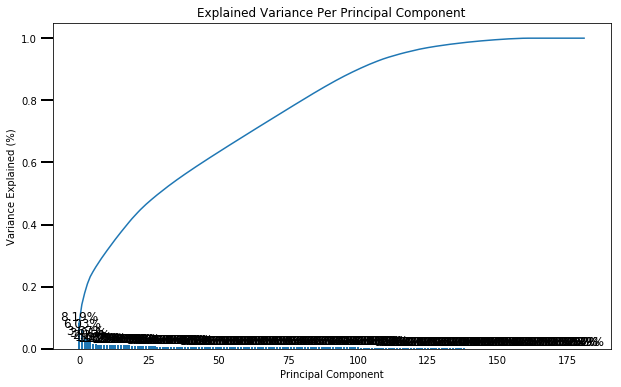

In [51]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_reducer)

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Get Number of Principal compenents that has sum of variance explained >= 0.90
pca_reducer = PCA(n_components=0.90, svd_solver='full')
pca_azdias = pd.DataFrame(pca_reducer.fit_transform(scaled_azdias))

Number of new columns:109


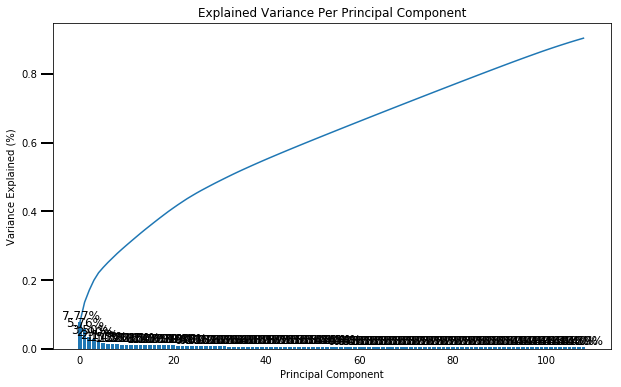

In [17]:
scree_plot(pca_reducer)
print(f"Number of new columns:{pca_azdias.shape[1]}")

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

1. Based on scree plot, I see that, the variance_explianed increase slowly by adding more principal component.
2. This is a bad situation because we need to have many principal component to able to represent the original data.
3. One of possible reason is: pd.get_dummies() created too many columns
3. I choose the threshold as 0.95 which means that the sum of variance_explianed of all principal component >= 0.95
4. We used 118 columns to represent 0.95% variance of the data
5. Shrink from 183 -> 102

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [18]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_pca_weights_link_with_names(i):
    pca_weights_wname = pd.Series(data = pca_reducer.components_[i], index=list(scaled_azdias.columns))
    print(pca_weights_wname.sort_values(ascending=False)[:5])
    print(list(pca_weights_wname.sort_values(ascending=False)[:5].index))
    print('-----------------------')
    print(pca_weights_wname.sort_values(ascending=True)[:5])
    print(list(pca_weights_wname.sort_values(ascending=True)[:5].index))
    print('-----------------------')
    print(pca_reducer.explained_variance_ratio_[i])
    return pca_weights_wname

In [19]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = get_pca_weights_link_with_names(0)

PLZ8_ANTG3                0.188247
CAMEO_INTL_2015_wealth    0.187418
HH_EINKOMMEN_SCORE        0.183819
PLZ8_ANTG4                0.183079
PLZ8_BAUMAX               0.179095
dtype: float64
['PLZ8_ANTG3', 'CAMEO_INTL_2015_wealth', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG4', 'PLZ8_BAUMAX']
-----------------------
MOBI_REGIO          -0.209179
KBA05_ANTG1         -0.196254
PLZ8_ANTG1          -0.189840
FINANZ_MINIMALIST   -0.188665
KBA05_GBZ           -0.185273
dtype: float64
['MOBI_REGIO', 'KBA05_ANTG1', 'PLZ8_ANTG1', 'FINANZ_MINIMALIST', 'KBA05_GBZ']
-----------------------
0.07775832207229443


In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = get_pca_weights_link_with_names(1)

ALTERSKATEGORIE_GROB    0.237941
FINANZ_VORSORGER        0.219555
ZABEOTYP_3              0.202043
SEMIO_ERL               0.188833
SEMIO_LUST              0.168480
dtype: float64
['ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'ZABEOTYP_3', 'SEMIO_ERL', 'SEMIO_LUST']
-----------------------
PRAEGENDE_JUGENDJAHRE_decade   -0.238642
FINANZ_SPARER                  -0.226940
SEMIO_REL                      -0.225636
SEMIO_PFLICHT                  -0.213956
SEMIO_TRADV                    -0.212716
dtype: float64
['PRAEGENDE_JUGENDJAHRE_decade', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_PFLICHT', 'SEMIO_TRADV']
-----------------------
0.0600674990205


In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_3 = get_pca_weights_link_with_names(2)

SEMIO_VERT     0.326108
SEMIO_SOZ      0.258106
SEMIO_FAM      0.256361
SEMIO_KULT     0.244569
FINANZTYP_5    0.145161
dtype: float64
['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT', 'FINANZTYP_5']
-----------------------
ANREDE_KZ    -0.345371
SEMIO_KAEM   -0.312968
SEMIO_DOM    -0.276800
SEMIO_KRIT   -0.260741
SEMIO_ERL    -0.197215
dtype: float64
['ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_ERL']
-----------------------
0.036566069512


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Principal Component 1**
- Top 5 positive correlation: 'PLZ8_ANTG3', 'CAMEO_INTL_2015_wealth', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE', 'PLZ8_BAUMAX'
- Conclusion: Very interesting, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX hold information about house held density in the area. CAMEO_INTL_2015_wealth held information about wealthy status. HH_EINKOMMEN_SCORE held information about household net income.
- Cleary, those 5 columns have some positive correlation to each other

- Top 5 negative correlation: 'MOBI_REGIO', 'KBA05_ANTG1', 'PLZ8_ANTG1', 'FINANZ_MINIMALIST', 'KBA05_GBZ'
- Compare with Top 5 positive correaltion.
- Conclusion: I dont see quite much constrast between them hence the relationship between top 5 positive correaltion and top 5 negative correlation does not have to be inverse

**Principal Component 2**
- Top 5 positive correlation: 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'ZABEOTYP_3', 'SEMIO_ERL', 'SEMIO_LUST'
- Intepreting: ALTERSKATEGORIE_GROB is about the age. FINANZ_VORSORGER is about financial typology which is 'be preapred'. SEMIO_ERL is about Personality typology which is 'event-oriented'. SEMIO_LUST is about Personality typology which is 'sensual-minded'. 
- Conclusion: Very intriguing, the story can tell from those 5 columns is: young people who has just take inital step on preparing for their financial. Because they are young people henece they have 'event-oriented' and 'sensual-minded'.

**Principal Component 3**
- Top 5 positive correlation: 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT', 'FINANZTYP_5'
- Intepreting: SEMIO_VERT is about Personality typology: 'dreamful'. SEMIO_SOZ is about Personality typology: 'socially-minded'. SEMIO_FAM is about Personality typology: 'family-minded'. SEMIO_KULT is about Personality typology: 'cultural-minded'. FINANZTYP_5 is: Most descriptive financial type for individual: 'investor'
- Conclusion: Very intriguing, the story can tell from those 5 columns is: investor in Germany tend to have these characteristic: dreamful, socially-minded, family-minded and cultural-minded


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [21]:
def get_kmeans_score(num_cluster, data, n_points):
    kmeans_model = KMeans(n_clusters=num_cluster, random_state=0).fit(data)
    # Because kmeans in sklearn = -1 * Sum_of_square_distance_of_point_to_its_centroid
    score_kmeans = abs(kmeans_model.score(data))
    
    # Get average of Sum_of_square_distance_of_point_to_its_centroid
    avg_score_kmeans = score_kmeans / n_points
    
    # return string to avoid OverflowError: cannot convert float infinity to integer
    return num_cluster, avg_score_kmeans

In [72]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
n_points = pca_azdias.shape[0]
data = pca_azdias
num_clusters = []
scores = []
# Kmeans cluster work with n_centroids start from >= 2
for i in range(2, 25):
    num_cluster, avg_score_kmeans = get_kmeans_score(i, data, n_points)
    
    num_clusters.append(num_cluster)
    scores.append(avg_score_kmeans) 

Text(0.5,1,'K vs Average SSE')

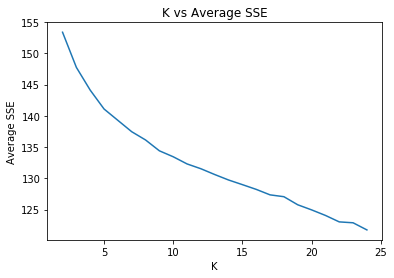

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters, scores)
plt.xlabel('K')
plt.ylabel('Average SSE')
plt.title('K vs Average SSE')

#### Use Silhoute to compare the fittness of model with different K

In [25]:
def get_silhoute_score(num_cluster, data):
    
    kmeans_model = KMeans(n_clusters=num_cluster, random_state=0).fit(data)
    
    sil_score = silhouette_score(data, kmeans_model.labels_)
        
    return num_cluster, sil_score

In [26]:
data = pca_azdias
num_clusters = []
sil_scores = []
for i in range(2, 25):
    num_cluster, sil_score = get_silhoute_score(i, data)
    
    num_clusters.append(num_cluster)
    sil_scores.append(sil_score) 

sil_scores

[0.06769115046470321,
 0.047928641581011185,
 0.05074884321665983,
 0.04605909634775677,
 0.03573827401944737,
 0.03579346114515192,
 0.03643428715072843,
 0.03558007333711137,
 0.03749765735047506,
 0.03624843755178271,
 0.037805277692400316,
 0.03468086463849984,
 0.041764453598254744,
 0.035142786642498695,
 0.034834917488264144,
 0.042935311345864736,
 0.04550988136334685,
 0.04281228440420181,
 0.03816466231690443,
 0.03861095221317424,
 0.050672975987663994,
 0.05730946681667366,
 0.04168605676435623]

Text(0.5, 1.0, 'K vs Silhoute Scores')

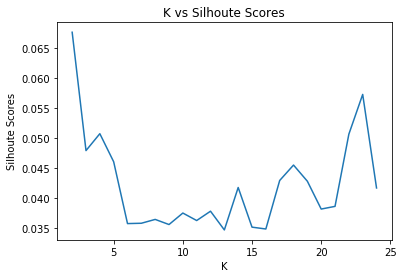

In [27]:
plt.plot(num_clusters, sil_scores)
plt.xlabel('K')
plt.ylabel('Silhoute Scores')
plt.title('K vs Silhoute Scores')

> **Based on K vs Silhoute Score, I choose K = 23**

In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
K = 23
data = pca_azdias
kmeans_model_23 = KMeans(n_clusters=K, random_state=0).fit(data)
demographic_labels = kmeans_model_23.predict(data)

Text(0.5,1,'Germany Demographic Groups')

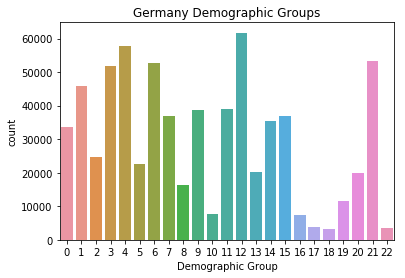

In [55]:
ax = sns.countplot(x=demographic_labels)
ax.set_xlabel("Demographic Group")
ax.set_title("Germany Demographic Groups")

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- Using elbow method and looking the graph of K vs Silhoute Score, I decided to choose number of cluster for KMean Clustering model is: K = 23
- Because our problem is unsupervised learning, and we used model is Kmean Clustering. Hence, Silhoute score is one of the best validation for our case.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [56]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

#### Fill NA in customers

In [57]:
def clean_data_customer(df, not_outlier_cols):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def get_data_type(col_name):
    
        a = [int, float, str]
        b = None
        data_type = azdias[col_name].dtype

        if (data_type == 'int'):
            b = a[0]
        elif (data_type == 'float'):
            b = a[1]
        else:
            b = a[2]

        return b
    
    azdias_filled_na = df.copy()
    
    # Identify missing or unknown data values and convert them to NaNs.
    for i, col_name in enumerate(list(azdias_filled_na.columns)):
        missing_or_unknown_values = feat_info['missing_or_unknown'][i]
        missing_or_unknown_values_list = missing_or_unknown_values[1:-1].split(',')

        if(missing_or_unknown_values != '[]'):
            data_type = get_data_type(col_name)
            missing_or_unknown_values_list = list(map(data_type, missing_or_unknown_values_list))
            azdias_filled_na[col_name].replace(missing_or_unknown_values_list, np.nan, inplace=True)
            
            
            
    
    # Filtered outlier colummns based on Germany Demographic Data
    not_outlier_column_names = not_outlier_cols
    azdias_col_outlier_filtered = azdias_filled_na[not_outlier_column_names].copy()
    
    
    
    
    
    # How much data is missing in each row of the dataset?
    # list contain the percentage of missing values in each rows of azdias_col_outlier_filtered
    mis_percentages_row = []
    mis_percentages_row = azdias_col_outlier_filtered.isna().sum(axis=1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.

    # threshold: number of missing values allowed in each row
    threshold = 20

    rows_below_threshold_id = mis_percentages_row[mis_percentages_row <= threshold].index
    rows_above_threshold_id = mis_percentages_row[mis_percentages_row > threshold].index

    azdias_outlier_filtered = azdias_col_outlier_filtered.iloc[rows_below_threshold_id, :]
    azdias_outlier_rows = azdias_col_outlier_filtered.iloc[rows_above_threshold_id, :]
    
    
    # select, re-encode, and engineer column values.
    
    # Get feature info of only filltered columns 
    feat_info_filtered_columns = feat_info[feat_info['attribute'].isin(list(azdias_outlier_filtered.columns))].copy()

    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    # Get names of catgorical columns
    cate_col_names = feat_info_filtered_columns[feat_info['type'] == 'categorical']['attribute']

    # Multilevel columns needed encode
    en_needed_multi_cols = []

    # Binary columns needed encode:
    en_needed_bi_cols = []

    # print column name and its unique values
    for col_name in cate_col_names:
        # number of unique values without na
        list_unique_values = list(azdias_outlier_filtered[col_name].value_counts(dropna = True).index)
        num_unique_values = len(list_unique_values)

        if (num_unique_values > 2):
            en_needed_multi_cols.append(col_name)

        else:
            # For binary columns, only encode if its elements are non-numeric
            if (not isinstance(list_unique_values[0], (int, float))):
                en_needed_bi_cols.append(col_name)

    
    # One hot columns:
    one_hot_columns = en_needed_multi_cols + en_needed_bi_cols
    
    # Re-encode categorical variable(s) to be kept in the analysis
    # Change type of one_hot_columns columns to category so later on can use pd.getdummies
    for col_name in one_hot_columns:
        azdias_outlier_filtered[col_name] = azdias_outlier_filtered[col_name].astype('category')

    # Get dummies variable of one_hot_columns
    # drop first to avoid dummy trap
    one_hot_encoded_cols = pd.get_dummies(azdias_outlier_filtered[one_hot_columns], drop_first=True)

    # Drop old one_hot_columns
    azdias_one_hot_encoded = azdias_outlier_filtered.drop(labels = one_hot_columns, axis=1)

    # concat azdias_one_hot_encoded with dummies variable of multilevel_cols
    azdias_one_hot_encoded = pd.concat([azdias_one_hot_encoded, one_hot_encoded_cols], axis = 1)
    
    n_rows = azdias_one_hot_encoded.shape[0]

    PRAEGENDE_JUGENDJAHRE_decade_convert = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    PRAEGENDE_JUGENDJAHRE_decade_boolean = [True] * n_rows

    # 0: Mainstream
    # 1: Avantgarde
    PRAEGENDE_JUGENDJAHRE_movement_convert = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    PRAEGENDE_JUGENDJAHRE_movement_boolean = [False] * n_rows
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # you should create two new variables to capture the other two dimensions:
    # an interval-type variable for decade, and a binary variable for movement.
    def get_convert_value_PRA(num, isDecade):
        if(np.isnan(num)):
            return np.nan
        num = int(num)
        if (isDecade):
            return PRAEGENDE_JUGENDJAHRE_decade_convert[num-1]
        else:
            return PRAEGENDE_JUGENDJAHRE_movement_convert[num-1]

    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = list(map(get_convert_value_PRA, \
                                                                      azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'],\
                                                                      PRAEGENDE_JUGENDJAHRE_decade_boolean))

    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = list(map(get_convert_value_PRA, \
                                                                    azdias_one_hot_encoded['PRAEGENDE_JUGENDJAHRE'], \
                                                                    PRAEGENDE_JUGENDJAHRE_movement_boolean))
    
    n_rows = azdias_one_hot_encoded.shape[0]

    CAMEO_INTL_2015_wealth_convert = [1, 2, 3, 4, 5]
    CAMEO_INTL_2015_wealth_boolean = [True] * n_rows

    CAMEO_INTL_2015_lifestage_convert = [1, 2, 3, 4, 5]
    CAMEO_INTL_2015_lifestage_boolean = [False] * n_rows
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
    # (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
    def get_convert_value_CAMEO(num, isWealth):
        if(np.isnan(num)):
            return np.nan
        num = int(num)
        if (isWealth):
            num = int(num/10)
            return CAMEO_INTL_2015_wealth_convert[num-1]
        else:
            num = int(num%5)
            return CAMEO_INTL_2015_lifestage_convert[num-1]

    # Convert CAMEO_INTL_2015 from category to float
    # Avoid np.isnan in get_convert_value_CAMEO failed with object data type
    azdias_one_hot_encoded['CAMEO_INTL_2015'] = azdias_one_hot_encoded['CAMEO_INTL_2015'].astype('float')

    azdias_one_hot_encoded['CAMEO_INTL_2015_wealth'] = list(map(get_convert_value_CAMEO, \
                                                                      azdias_one_hot_encoded['CAMEO_INTL_2015'],\
                                                                      CAMEO_INTL_2015_wealth_boolean))

    azdias_one_hot_encoded['CAMEO_INTL_2015_lifestage'] = list(map(get_convert_value_CAMEO, \
                                                                    azdias_one_hot_encoded['CAMEO_INTL_2015'], \
                                                                    CAMEO_INTL_2015_lifestage_boolean))
    
    # Drop original columns after engineering
    azdias_one_hot_encoded.drop(labels=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    df_clean = azdias_one_hot_encoded.copy()
    # Return the cleaned dataframe.
    return df_clean

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Drop not_outlier_column_names same as demographic data 
# Because we want customers_cleaned have identical columns as azdias_clean
# Dont need to drop 'GEBAEUDETYP_5.0' like azdias_clean because customers_cleaned do not have 'GEBAEUDETYP_5.0' column
customers_cleaned = clean_data_customer(customers, not_outlier_cols=not_outlier_column_names)


imputed_customers = pd.DataFrame(fill_NaN.transform(customers_cleaned))
imputed_customers.columns = customers_cleaned.columns
imputed_customers.index = customers_cleaned.index

scaled_customers = pd.DataFrame(standard_scaler.transform(imputed_customers))
scaled_customers.columns = imputed_customers.columns
scaled_customers.index = imputed_customers.index


pca_customers = pd.DataFrame(pca_reducer.transform(scaled_customers))

customer_labels = kmeans_model_23.predict(pca_customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
# check to see if customers_cleaned have same columns with azdias_clean
cus_cols = list(customers_cleaned.columns)
for col in list(azdias_clean.columns):
    if(not (col in cus_cols)):
        print(col)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [68]:
import scipy
from scipy.stats import ks_2samp, mannwhitneyu

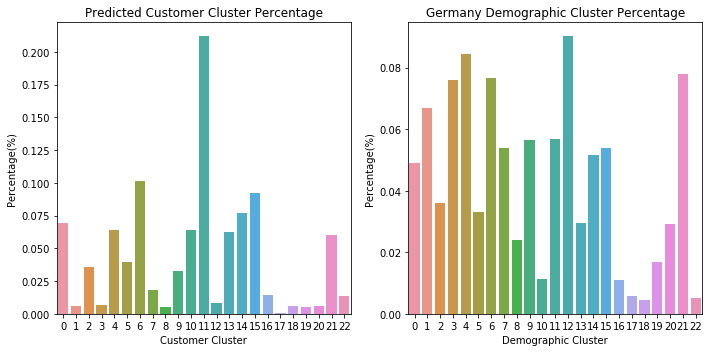

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customer_labels_series = pd.Series(customer_labels, copy=True)
n_people_customer = customer_labels_series.shape[0]
customer_pred_group_per = (customer_labels_series.value_counts()/n_people_customer)
customer_pred_group_per.sort_index(inplace=True)

pop_labels_series = pd.Series(demographic_labels, copy=True)
n_people_pop = pop_labels_series.shape[0]
pop_pred_group_per = (pop_labels_series.value_counts()/n_people_pop)
pop_pred_group_per.sort_index(inplace=True)

f = plt.figure(figsize=(10,5))

ax1 = f.add_subplot(1, 2, 1)
ax1 = sns.barplot(x=customer_pred_group_per.index, y=customer_pred_group_per)
ax1.set_xlabel("Customer Cluster")
ax1.set_ylabel("Percentage(%)")
ax1.set_title("Predicted Customer Cluster Percentage")

ax2 = f.add_subplot(1, 2, 2)
ax2 = sns.barplot(x=pop_pred_group_per.index, y=pop_pred_group_per)
ax2.set_xlabel("Demographic Cluster")
ax2.set_ylabel("Percentage(%)")
ax2.set_title("Germany Demographic Cluster Percentage")


plt.tight_layout()

In [70]:
# f = plt.figure(figsize=(10,5))

# ax1 = f.add_subplot(1, 2, 1)
# ax1 = sns.countplot(x=customer_labels)
# ax1.set_xlabel("Customer Group")
# ax1.set_title("Predicted Customer Groups")

# ax2 = f.add_subplot(1, 2, 2)
# ax2 = sns.countplot(x=demographic_labels)
# ax2.set_xlabel("Demographic Group")
# ax2.set_title("Germany Demographic Groups")


# plt.tight_layout()

#### Convert Data Frame under PCA back to original version

In [195]:
def convert_back_to_orgi_df(df):
    
    target_cus_pca_df = df.copy()
    
    # Convert back to original data type PCA, Standard Scaler
    target_cus_df = pd.DataFrame(pca_reducer.inverse_transform(target_cus_pca_df),\
                                 columns=scaled_customers.columns)

    target_cus_imputed = pd.DataFrame(standard_scaler.inverse_transform(target_cus_df), \
                                columns=scaled_customers.columns)
    
    # Convert Ordinal and Dummies columns from float to int
   
    ordi_cols = feat_info[(feat_info['type'] == 'ordinal')]['attribute']
    ordi_cols = list(ordi_cols)

    azdias_pre_dummies = azdias_outlier_filtered.drop(labels = one_hot_columns, axis=1)
    pre_dummies_cols = list(azdias_pre_dummies)
    dummies_cols = [col for col in list(target_cus_imputed) if (not(col in pre_dummies_cols))]

    need_convert_cols = ordi_cols + dummies_cols
    
    def convert_col_to_int(df, col_name):
        df[col_name] = df[col_name].apply(int)
        # Because they are ordinal and dummies column
        # Hence all value has to be positive
        df[col_name] = df[col_name].apply(abs)

    for col_name in need_convert_cols:
        convert_col_to_int(target_cus_imputed, col_name)
        
    return target_cus_imputed

#### Calculating percentage of ordinal and dummies columns
- Catch out any columns which has an element that dominate more than 50% distribution of that column
- Put all calculation to new data frame: over_represent_df

In [141]:
def catch_spcecial_from_df(df):
    
    target_cus_imputed = df.copy()
    
    def catch_special_col(col_name, n_rows, target_cus_imputed):
        element_per = target_cus_imputed[col_name].value_counts() / n_rows
        element_per.sort_values(ascending=False, inplace=True)
        element_per_list = list(element_per)
        highest_per = element_per_list[0]

        if (len(element_per_list) == 2):
            highest_per = sum(element_per_list) / n_rows

        if (highest_per >= 0.5 and len(element_per_list) > 2):
            return True, element_per, highest_per
        else:
            return False, element_per, highest_per

    n_rows = target_cus_imputed.shape[0]
    spec_cols = []
    element_pers = []
    highest_pers = []

    for col_name in need_convert_cols:
        isSpecial, element_per, highest_per = catch_special_col(col_name, n_rows, target_cus_imputed)
        if(isSpecial):
            spec_cols.append(col_name)
            element_pers.append(element_per)
            highest_pers.append(highest_per)
            
    return spec_cols, element_pers, highest_pers

#### Over Represent Group of Customer Cluster

In [142]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Clearly that customer cluster label 11 is overrepresented in Customer Cluster data
over_represent_cus_group = 11

# Retrieve information of cluster_11 from Customer Cluster
target_cus_pca_df = pca_customers[customer_labels == over_represent_cus_group]
target_cus_imputed = convert_back_to_orgi_df(target_cus_pca_df)
tar_spec_cols, tar_element_pers, tar_highest_pers = catch_spcecial_from_df(target_cus_imputed)

over_represent_df = pd.DataFrame(data=list(zip(tar_spec_cols, tar_element_pers, tar_highest_pers)))
over_represent_df.columns = ['SPECIAL_COLUMNS', 'DETAILED_PER', 'HIGHEST_PER']
over_represent_df.head()

,SPECIAL_COLUMNS,DETAILED_PER,HIGHEST_PER
0,ALTERSKATEGORIE_GROB,3 0.624425 4 0.199400 2 0.159114 1 ...,0.624425
1,FINANZ_MINIMALIST,5 0.503899 4 0.482073 3 0.013829 2 ...,0.503899
2,FINANZ_VORSORGER,5 0.519527 4 0.351783 3 0.089470 1 ...,0.519527
3,FINANZ_ANLEGER,0 0.548017 1 0.315128 2 0.105565 3 ...,0.548017
4,FINANZ_UNAUFFAELLIGER,1 0.673809 2 0.242286 0 0.040453 4 ...,0.673809


#### Over Reprensent Customer Have Some Needed Notice Columns

In [148]:
# Top 5 Special Columns from over_represent_df
top_5_over_lis = over_represent_df.sort_values(by = 'HIGHEST_PER', ascending=False)['SPECIAL_COLUMNS'][:5]
detailed_top_5_over_lis = list(over_represent_df[over_represent_df['SPECIAL_COLUMNS'].isin(top_5_over_lis)]['DETAILED_PER'])

In [149]:
detailed_top_5_over_lis[0]

8     0.695801
9     0.257314
7     0.033322
6     0.010430
5     0.002499
10    0.000566
4     0.000067
Name: WOHNDAUER_2008, dtype: float64

In [150]:
detailed_top_5_over_lis[1]

0    0.987038
1    0.012296
2    0.000600
3    0.000067
Name: KBA05_ANTG3, dtype: float64

In [151]:
detailed_top_5_over_lis[2]

4    0.713496
3    0.281473
2    0.003032
5    0.001666
1    0.000333
Name: KBA05_GBZ, dtype: float64

In [152]:
detailed_top_5_over_lis[3]

4    0.710063
3    0.261879
5    0.020593
2    0.007164
1    0.000300
Name: MOBI_REGIO, dtype: float64

In [153]:
detailed_top_5_over_lis[4]

0    0.955681
1    0.044285
2    0.000033
Name: PLZ8_ANTG4, dtype: float64

#### Under Represent Group of Customer Cluster

In [196]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clearly that customer cluster label 17 is overrepresented in Customer Cluster data
under_represent_cus_group = 17

# Retrieve information of cluster_17 from Demographic Cluster
under_cus_pca_df = pca_customers[customer_labels == under_represent_cus_group]
under_cus_imputed = convert_back_to_orgi_df(under_cus_pca_df)

und_spec_cols, und_element_pers, und_highest_pers = catch_spcecial_from_df(under_cus_imputed)

under_represent_df = pd.DataFrame(data=list(zip(und_spec_cols, und_element_pers, und_highest_pers)))
under_represent_df.columns = ['SPECIAL_COLUMNS', 'DETAILED_PER', 'HIGHEST_PER']
under_represent_df.head()

,SPECIAL_COLUMNS,DETAILED_PER,HIGHEST_PER
0,HEALTH_TYP,2 0.550725 1 0.384058 3 0.043478 0 ...,0.550725
1,W_KEIT_KIND_HH,0 0.594203 1 0.355072 2 0.043478 3 ...,0.594203
2,KBA05_ANTG2,0 0.514493 1 0.253623 2 0.166667 3 ...,0.514493
3,KBA05_ANTG3,0 0.804348 1 0.130435 2 0.065217 Name...,0.804348
4,ONLINE_AFFINITAET,4 0.500000 3 0.340580 2 0.079710 5 ...,0.500000


#### Under Reprensent Customer Have Some Needed Notice Columns

In [222]:
# Top 5 Special Columns from over_represent_df
top_5_under_lis = under_represent_df.sort_values(by = 'HIGHEST_PER', ascending=False)['SPECIAL_COLUMNS'][:5]
detailed_top_5_under_lis = list(under_represent_df[under_represent_df['SPECIAL_COLUMNS'].isin(top_5_under_lis)]\
                               ['DETAILED_PER']).copy()

In [209]:
detailed_top_5_under_lis[0]

2    0.550725
1    0.384058
3    0.043478
0    0.021739
Name: HEALTH_TYP, dtype: float64

In [227]:
# Because W_KEIT_KIND_HH could not have 0 as member
# Hence add up percentage of 0 to 1
# detailed_top_5_under_lis[1][1] = detailed_top_5_under_lis[1][0] + detailed_top_5_under_lis[1][1]

detailed_top_5_under_lis[1].drop(0)

1    0.949275
2    0.043478
3    0.007246
Name: W_KEIT_KIND_HH, dtype: float64

In [228]:
detailed_top_5_under_lis[2]

0    0.514493
1    0.253623
2    0.166667
3    0.050725
4    0.014493
Name: KBA05_ANTG2, dtype: float64

In [229]:
detailed_top_5_under_lis[3]

0    0.804348
1    0.130435
2    0.065217
Name: KBA05_ANTG3, dtype: float64

In [230]:
detailed_top_5_under_lis[4]

0    0.739130
1    0.246377
2    0.014493
Name: PLZ8_ANTG4, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Overresent Customer:**

- Cluster Number: 11
- Spcecials:

    <ol>

    <li>'WOHNDAUER_2008': Length of Residency, detailed_top_5_over_lis[0] </li>
    
        - 70% has length of residence 7-10 years
        - 25% has length of residence more than 10 years
        
    <li>'KBA05_ANTG3': Number of 6-10 family houses in the microcell, detailed_top_5_over_lis[1]: </li>
    
        - 98.7% no 6-10 family homes
        
    <li>'KBA05_GBZ', Number of buildings in the microcell, detailed_top_5_over_lis[2]: </li>
    
        - 71% 17-22 buildings
        - 28% 5-16 buildings
       
    <li>'MOBI_REGIO', Movement patterns, detailed_top_5_over_lis[3] </li>
    
        - 71% low movement
        - 26% middle movement
        
    <li>'PLZ8_ANTG4', Number of 10+ family houses in the PLZ8 region ,detailed_top_5_over_lis[4] </li>
        
        - 95.5% no 10+ family homes
    </ol>
    
    
**Underrepresent Customer:**

- Cluster Number: 17
- Spcecials:

    <ol>

    <li>'HEALTH_TYP': Health typology, detailed_top_5_under_lis[0] </li>
    
        - 55% sanitary affine
        - 38% critical reserved
        
    <li>'W_KEIT_KIND_HH': Likelihood of children in household, detailed_top_5_under_lis[1]: </li>
    
        - 95% most likely
        
    <li>'KBA05_ANTG2', Number of 3-5 family houses in the microcell, detailed_top_5_under_lis[2]: </li>
    
        - 51% no 3-5 family homes
        - 25% lower share of 3-5 family homes
        - 16% average share of 3-5 family homes
       
    <li>'KBA05_ANTG3', Number of 6-10 family houses in the microcell, detailed_top_5_under_lis[3] </li>
    
        - 80% no 6-10 family homes
        - 13% lower share of 6-10 family homes
        
    <li>'PLZ8_ANTG4', Number of 10+ family houses in the PLZ8 region ,detailed_top_5_under_lis[4] </li>
        
        - 74% no 10+ family homes
        - 25% lower share of 10+ family homes
    </ol>









> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.